## Post processing of aboveground biomass dataset 

### Input
Random forest model prediction results from inference.ipynb. These are parquet files (1 for each landsat scene x year) with columns x, y, biomass.  x, y are in lat/lon coordinates, and biomass is in unit of Mg biomass / ha and only accounts for aboveground, live, woody biomass. 

### Processes
For each 10x10 degree tile in our template 
1. merge and mosaic all landsat scenes within a 10x10 degree tile for all years available and store the data in zarr format 
2. fill gaps within the biomass dataset by xarray interpolate_na with linear method (first through dim time, then through dim x, then dim y)
3. mask with MODIS MCD12Q1 land cover dataset to only select the forest pixels
4. calculate belowground biomass and deadwood and litter 

### To do
1. take diff between years to calculate biomass change 
2. co-locate with fire 
3. use emission factor to calculate fire related emissions 
4. calculate non fire related emissions 
5. convert to mass and roll up by country 
6. test

In [1]:
%load_ext autoreload
%autoreload 2

from pyproj import CRS
import boto3
from rasterio.session import AWSSession
from s3fs import S3FileSystem
aws_session = AWSSession(boto3.Session(),#profile_name='default'), 
                         requester_pays=True)
fs = S3FileSystem(requester_pays=True)
import xgboost as xgb

from osgeo.gdal import VSICurlClearCache
import rasterio as rio
import numpy as np
import xarray as xr
import dask
import os
import fsspec

import rioxarray # for the extension to load
import pandas as pd
from datetime import datetime

from dask_gateway import Gateway
from carbonplan_trace.v1.landsat_preprocess import access_credentials, test_credentials
from carbonplan_trace.v1.inference import predict, predict_delayed
from carbonplan_trace.v1 import utils


In [ ]:
from carbonplan_trace import version

print(version)

In [ ]:
# kind_of_cluster = "local"
kind_of_cluster = "remote"
if kind_of_cluster == "local":
    # spin up local cluster. must be on big enough machine
    from dask.distributed import Client

    client = Client(
        n_workers=4, 
        threads_per_worker=8,
    )
    client
else:
    gateway = Gateway()
    options = gateway.cluster_options()
    options.environment = {
        "AWS_REQUEST_PAYER": "requester",
        "AWS_REGION_NAME": "us-west-2",
    }
    options.worker_cores = 1
    options.worker_memory = 200
    
    options.image = "carbonplan/trace-python-notebook:latest"
    cluster = gateway.new_cluster(cluster_options=options)
    cluster.scale(40)

In [ ]:
cluster

In [ ]:
client = cluster.get_client()
client

In [42]:
from carbonplan_trace.tiles import tiles
tiles

['00N_000E',
 '00N_010E',
 '00N_020E',
 '00N_030E',
 '00N_040E',
 '00N_040W',
 '00N_050W',
 '00N_060W',
 '00N_070E',
 '00N_070W',
 '00N_080W',
 '00N_090E',
 '00N_090W',
 '00N_100E',
 '00N_100W',
 '00N_110E',
 '00N_120E',
 '00N_130E',
 '00N_140E',
 '00N_150E',
 '00N_160E',
 '10N_000E',
 '10N_010E',
 '10N_010W',
 '10N_020E',
 '10N_020W',
 '10N_030E',
 '10N_040E',
 '10N_050E',
 '10N_050W',
 '10N_060W',
 '10N_070E',
 '10N_070W',
 '10N_080E',
 '10N_080W',
 '10N_090E',
 '10N_090W',
 '10N_100E',
 '10N_100W',
 '10N_110E',
 '10N_120E',
 '10N_130E',
 '10S_010E',
 '10S_020E',
 '10S_030E',
 '10S_040E',
 '10S_040W',
 '10S_050E',
 '10S_050W',
 '10S_060W',
 '10S_070W',
 '10S_080W',
 '10S_110E',
 '10S_120E',
 '10S_130E',
 '10S_140E',
 '10S_150E',
 '10S_160E',
 '10S_170E',
 '10S_180W',
 '20N_000E',
 '20N_010E',
 '20N_010W',
 '20N_020E',
 '20N_020W',
 '20N_030E',
 '20N_040E',
 '20N_050E',
 '20N_060W',
 '20N_070E',
 '20N_070W',
 '20N_080E',
 '20N_080W',
 '20N_090E',
 '20N_090W',
 '20N_100E',
 '20N_100W',

In [ ]:
# find existing output and skip those, something like this 

# processed_scenes = []
# for year in np.arange(2015, 2021):
#     processed_scenes.extend(
#         fs.ls(f"{bucket}/inference/rf/{year}", recursive=True)
#     )

# processed_scenes = [scene[-19:-8] for scene in processed_scenes]

In [ ]:
def postprocess(tile, y0=2014, y1=2020):
    # finding all 2x2 tiles 
    
    
    subtiles = 
    # distributed or serial 
    out = []
    for np.arange(y0, y1+1):
        out.append(merge_by_latlon)
    xr.merge(out)

In [ ]:
tasks = []
for tile in tiles:
    if tile not in already_processed:
        lat_tag, lon_tag = get_lat_lon_tags_from_tile_path(tile)
        lat_lon_box = parse_bounding_box_from_lat_lon_tags(lat_tag, lon_tag)
        min_lat, max_lat, min_lon, max_lon = lat_lon_box 
        # initialize empty dataset 
        
        
        # find all 2x2 degree tiles within the 
        tasks.append(client.compute(postprocess(tile)))

In [ ]:
len(tasks)

In [43]:
test = xr.open_zarr('s3://carbonplan-climatetrace/junk/test.zarr')
test.load()

<xarray.Dataset>
Dimensions:  (y: 8000, x: 8000)
Coordinates:
  * x        (x) float64 -70.0 -70.0 -70.0 -70.0 ... -68.0 -68.0 -68.0 -68.0
  * y        (y) float64 -2.0 -2.0 -1.999 ... -0.000625 -0.000375 -0.000125
Data variables:
    biomass  (y, x) float64 295.3 295.4 295.3 295.4 ... 199.0 196.6 204.5 197.2

In [44]:
test.nbytes / 1e9

0.512128

In [28]:
t2 = postprocess(test)
# get hansen as a water mask (or find something at 30m, or reprocess landsat :( )

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [ ]:
hansen = load.treecover2000(test, ['00N_070W'], lat_lon_box=[lat], dtype='int8')

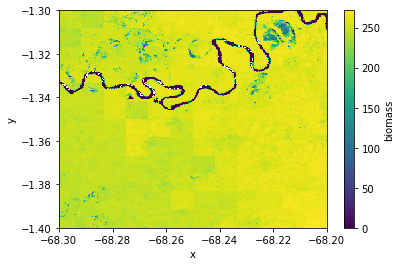

In [41]:
test.biomass.sel(x=slice(-68.3, -68.2), y=slice(-1.4, -1.3)).plot()

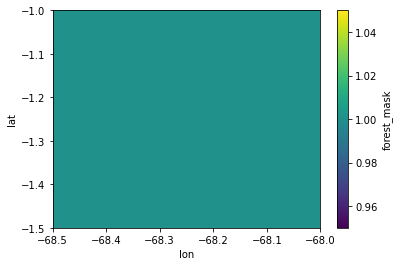

In [39]:
t2.forest_mask.sel(lon=slice(-68.5, -68), lat=slice(-1.5, -1)).plot()

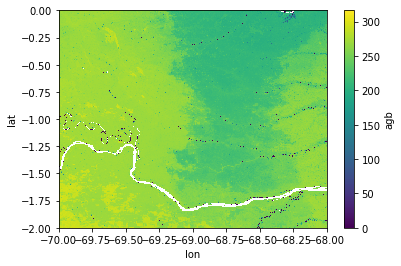

In [141]:
t2.agb.plot()

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [66]:
t2.agb.isnull().sum()

<xarray.DataArray 'agb' ()>
array(0)

In [67]:
test

<xarray.Dataset>
Dimensions:  (y: 8000, x: 8000)
Coordinates:
  * x        (x) float64 -70.0 -70.0 -70.0 -70.0 ... -68.0 -68.0 -68.0 -68.0
  * y        (y) float64 -2.0 -2.0 -1.999 ... -0.000625 -0.000375 -0.000125
Data variables:
    biomass  (y, x) float64 295.3 295.4 295.3 295.4 ... 199.0 196.6 204.5 197.2